# <center> ASSIGNMENT 3 </center>
## <center> Regression Analysis using Linear and Regularized Models </center>

# Assignment 3

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
import seaborn as sns

In [75]:
train_df = pd.read_csv(r"datasets\dataset3_train.csv")
test_df = pd.read_csv(r"datasets\dataset3_test.csv")

train_df.info()
# test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  30000 non-null  object 
 1   Name                         30000 non-null  object 
 2   Gender                       29947 non-null  object 
 3   Age                          30000 non-null  int64  
 4   Income (USD)                 25424 non-null  float64
 5   Income Stability             28317 non-null  object 
 6   Profession                   30000 non-null  object 
 7   Type of Employment           22730 non-null  object 
 8   Location                     30000 non-null  object 
 9   Loan Amount Request (USD)    30000 non-null  float64
 10  Current Loan Expenses (USD)  29828 non-null  float64
 11  Expense Type 1               30000 non-null  object 
 12  Expense Type 2               30000 non-null  object 
 13  Dependents      

## Data Preprocessing

### Filtering unnecessary columns

In [76]:
train_df.drop(["Customer ID", "Name"],axis = 1, inplace=True)

### Encoding Categorical Variables

In [77]:


#ordinal encodings
ordinal_encodings = {
    "Income Stability":['Low', 'High'],
    "Location":['Rural', 'Semi-Urban', 'Urban'],
    "Has Active Credit Card":['Unpossessed', 'Inactive', 'Active'],
    "Property Location":['Rural', 'Semi-Urban', 'Urban'],
    "Gender": ["M","F"],
    "Expense Type 1": ['Y', 'N'],
    "Expense Type 2": ['Y', 'N']
}

columns_to_rank = {
    "Profession":{'Working':0, 'Pensioner':0, 'State servant':0, 'Commercial associate':0, 'Unemployed':0, 'Student':0, 'Businessman':0, 'Maternity leave':0},
    "Type of Employment":{'Sales staff':0, 'High skill tech staff':0, 'Secretaries':0, 'Laborers':0, 'Managers':0, 'Cooking staff':0, 'Core staff':0, 'Drivers':0, 'Realty agents':0, 'Security staff':0, 'Accountants':0, 'Private service staff':0, 'Waiters/barmen staff':0, 'Medicine staff':0, 'Cleaning staff':0, 'Low-skill Laborers':0, 'HR staff':0, 'IT staff':0},
}

for column in columns_to_rank:
    for param in columns_to_rank[column]:
        avg = train_df[train_df[column]==param]["Loan Sanction Amount (USD)"].mean()
        columns_to_rank[column][param]=avg

ordinal_encodings['Profession'] = sorted(columns_to_rank["Profession"], key = lambda x: columns_to_rank["Profession"][x])
ordinal_encodings['Type of Employment'] = sorted(columns_to_rank["Type of Employment"], key = lambda x: columns_to_rank["Type of Employment"][x])

for column in ordinal_encodings:
    encoder = OrdinalEncoder(
        categories=[ordinal_encodings[column]],
        handle_unknown="use_encoded_value",
        unknown_value=np.nan
    )
    encoder.set_output(transform="pandas")
    train_df[column] = encoder.fit_transform(train_df[[column]])


### Handling null values

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       29947 non-null  float64
 1   Age                          30000 non-null  int64  
 2   Income (USD)                 25424 non-null  float64
 3   Income Stability             28317 non-null  float64
 4   Profession                   30000 non-null  float64
 5   Type of Employment           22730 non-null  float64
 6   Location                     30000 non-null  float64
 7   Loan Amount Request (USD)    30000 non-null  float64
 8   Current Loan Expenses (USD)  29828 non-null  float64
 9   Expense Type 1               30000 non-null  float64
 10  Expense Type 2               30000 non-null  float64
 11  Dependents                   27507 non-null  float64
 12  Credit Score                 28297 non-null  float64
 13  No. of Defaults 

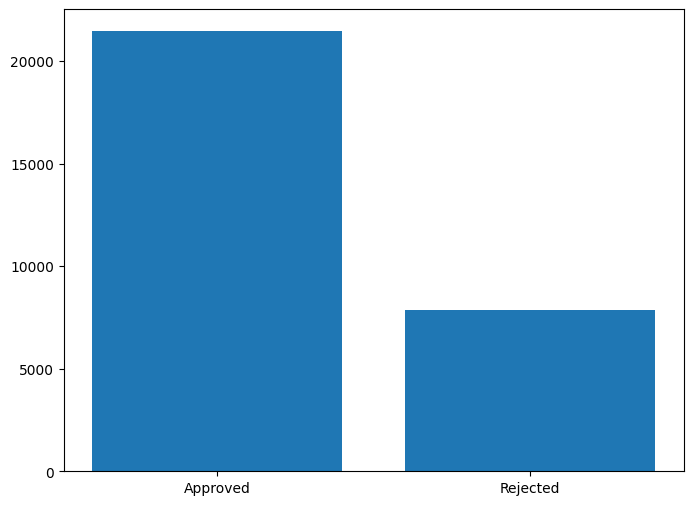

In [79]:
### too many loans(~7000) have been rejected (given a 0 value)

approved = train_df[train_df["Loan Sanction Amount (USD)"] > 0]
rejected = train_df[train_df["Loan Sanction Amount (USD)"] == 0]
counts = [len(approved), len(rejected)]
labels = ["Approved", "Rejected"]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)
plt.savefig(f"latex/images/rejected_loans.pdf", bbox_inches='tight')
plt.show()

In [7]:
## we observe -999 used as nulll values in following columns
null_999 = [
    "Loan Sanction Amount (USD)",   ##338 -999 values
    "Property Price",               ##341 -999 values
    "Co-Applicant",                 ##165 -999 values
    "Current Loan Expenses (USD)"   ##174 -999 values
]

train_df[null_999] = train_df[null_999].replace(-999,np.nan)
train_df["Loan Sanction Amount (USD)"] = train_df["Loan Sanction Amount (USD)"].replace(0,np.nan)
train_df["Property Age Null"] = train_df["Property Age"].isna().astype(int)
train_df["Employment Null"] = train_df["Type of Employment"].isna().astype(int)
null_columns = ["Gender", "Income (USD)", "Income Stability", "Type of Employment", "Current Loan Expenses (USD)", "Dependents", "Credit Score", "Has Active Credit Card", "Property Age", "Property Location"]
## we observe null values present in following columns

###Since loan sanction amount is the value to be predicted, columns with loansanctionamount null are removed
train_df.dropna(subset=["Loan Sanction Amount (USD)"],inplace=True)

#imputation
## fill median for Income (USD), Gender, Income Stability, Type of Employment, Current Loan Expenses (USD), Credit Score, Property Age
## fill 0 for Dependents
## fill Unposessed for Has Active Credit Card
## fill most frequent for Property Location


train_df["Dependents"] = train_df["Dependents"].fillna(0)
train_df["Has Active Credit Card"] = train_df["Has Active Credit Card"].fillna(0)
train_df["Property Location"] = train_df["Property Location"].fillna(1)
train_df["Gender"] = train_df["Gender"].fillna(0)
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer.set_output(transform="pandas")
train_df = imputer.fit_transform(train_df)



### standardizing numerical data

In [8]:
X = train_df.drop(["Loan Sanction Amount (USD)","Loan Amount Request (USD)", "Property Price"], axis = 1)
y = train_df[["Loan Sanction Amount (USD)"]].copy()

## propert age, price, all usd have outliers

X["Current Loan Expenses (USD)"] = X["Current Loan Expenses (USD)"].apply(np.log1p)
X["Income (USD)"] = X["Income (USD)"].apply(np.log1p)
# X["Loan Amount Request (USD)"] = X["Loan Amount Request (USD)"].apply(np.log1p)
# X["Property Price"] = X["Property Price"].apply(np.log1p)
X["Property Age"] = X["Property Age"].apply(np.log1p)

y["Loan Sanction Amount (USD)"] = y["Loan Sanction Amount (USD)"].apply(np.log1p)

scaler = StandardScaler()
scaler.set_output(transform="pandas")

standard_scale_columns = [
    'Age', 'Income (USD)', 'Profession', 'Type of Employment', 'Location', 
    # 'Loan Amount Request (USD)', 'Property Price',
      'Current Loan Expenses (USD)', 'Dependents', 
    'Credit Score', 'Has Active Credit Card', 'Property ID', 'Property Age', 
    'Property Type', 'Property Location'
]

for column in standard_scale_columns:
    X[column] = scaler.fit_transform(X[[column]])


## EDA

In [9]:
categorical_columns = [] # barchart
continuous_columns = [] # histogram
target_columns = ["Loan Sanction Amount (USD)"] #histogram
for i in X.columns:
    if len(X[i].unique())<20:
        categorical_columns.append(i)
    else:
        continuous_columns.append(i)

print(categorical_columns)
print(continuous_columns)
## 15 binary, 8 non binary, 1 target - 3 columns, 8 rows 


['Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Dependents', 'No. of Defaults', 'Has Active Credit Card', 'Property Type', 'Property Location', 'Co-Applicant', 'Property Age Null', 'Employment Null']
['Age', 'Income (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property ID', 'Property Age']


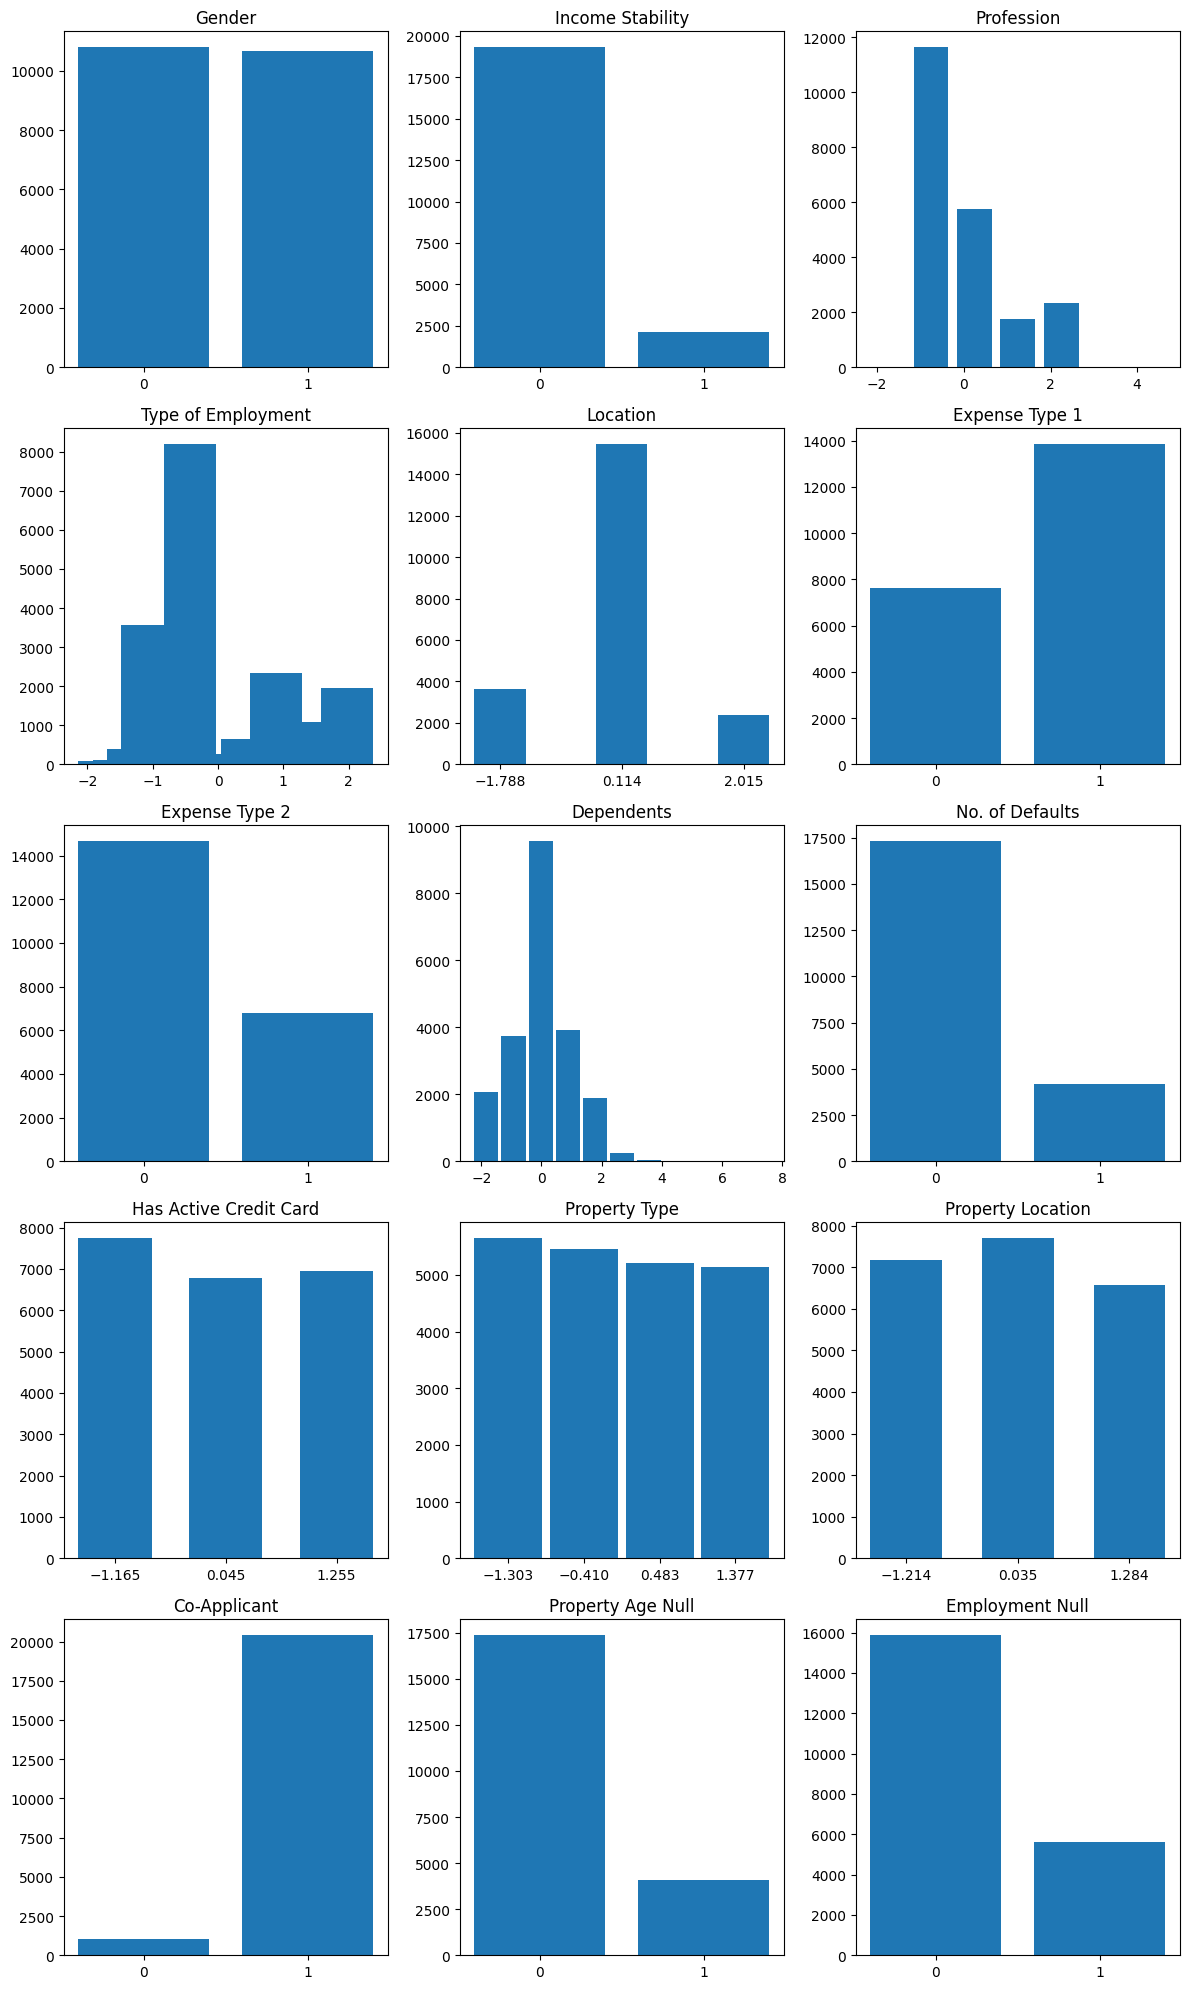

In [ ]:
fig,axes = plt.subplots(nrows = 5, ncols = 3, figsize = (12,20))
axes = axes.flatten()
for i in range(15):
    categories = sorted(X[categorical_columns[i]].unique())
    heights = [X[X[categorical_columns[i]]==j][categorical_columns[i]].count() for j in categories]

    axes[i].set_title(categorical_columns[i])
    axes[i].bar(categories,heights)
    if len(categories)<5:
        axes[i].set_xticks(categories)

plt.tight_layout()

plt.show()

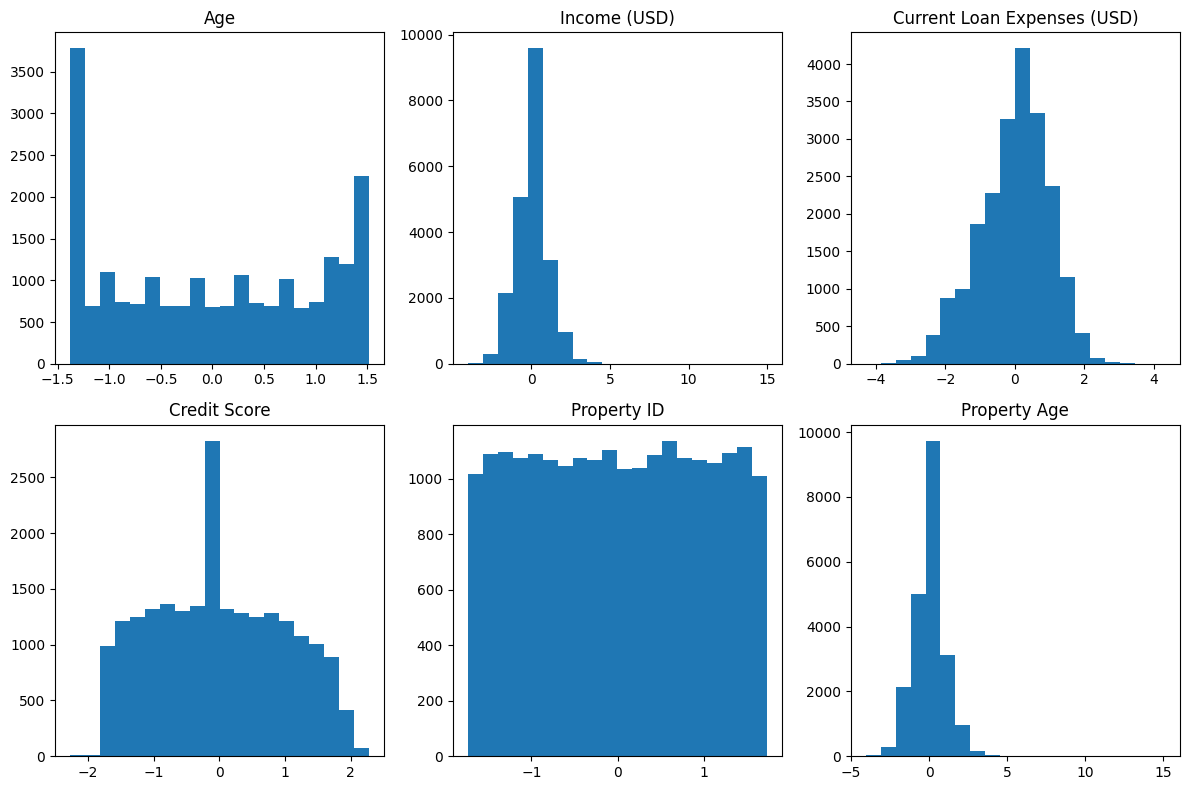

In [62]:
fig,axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12,8))
axes = axes.flatten()
for i in range(len(continuous_columns)):
    axes[i].hist(X[continuous_columns[i]],bins=20)
    # axes[i].scatter(x=range(len(X)),y=X[continuous_columns[i]])
    axes[i].set_title(continuous_columns[i])

plt.tight_layout()
plt.savefig(f"latex/images/histograms.pdf", bbox_inches='tight')
plt.show()

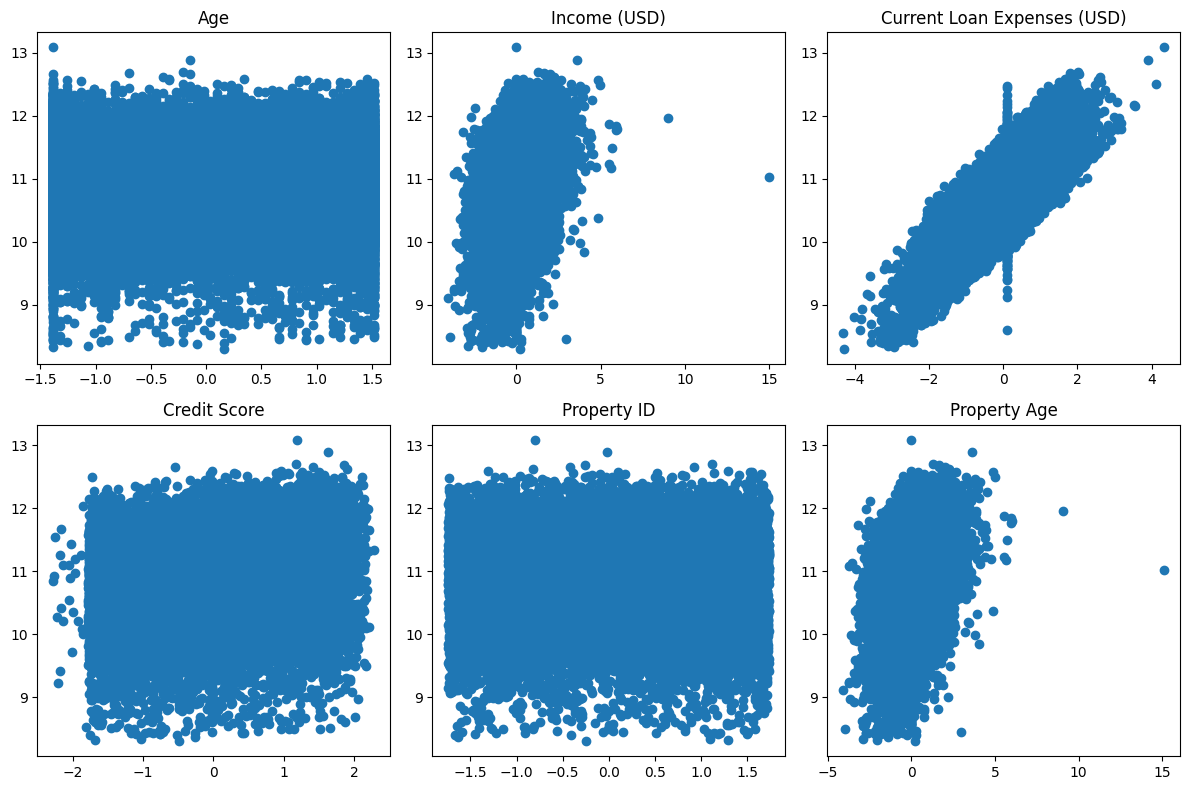

In [63]:
fig,axes = plt.subplots(nrows = 2, ncols = 3, figsize = (12,8))
axes = axes.flatten()
for i in range(len(continuous_columns)):
    axes[i].scatter(x=X[continuous_columns[i]],y=y["Loan Sanction Amount (USD)"])
    axes[i].set_title(continuous_columns[i])


plt.tight_layout()
plt.savefig(f"latex/images/scatterplots.pdf", bbox_inches='tight')
plt.show()

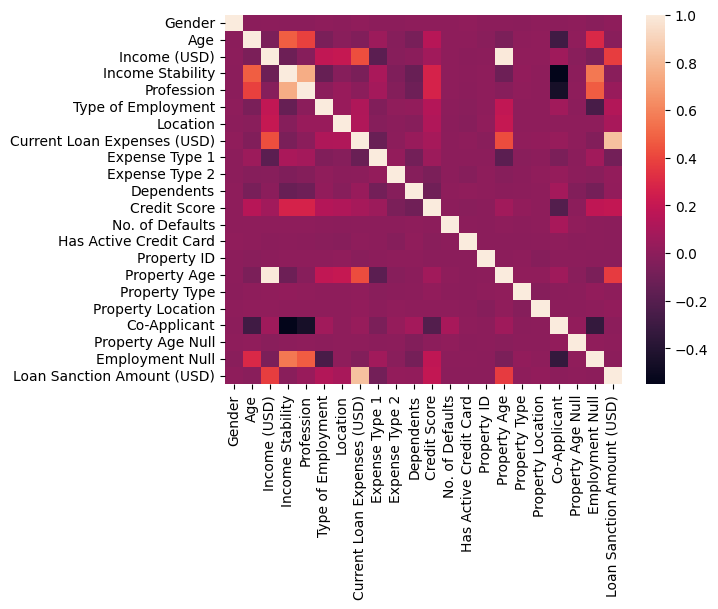

In [64]:
df = pd.concat([X,y],axis=1)
sns.heatmap(df.corr())
plt.savefig(f"latex/images/heatmap.pdf", bbox_inches='tight')


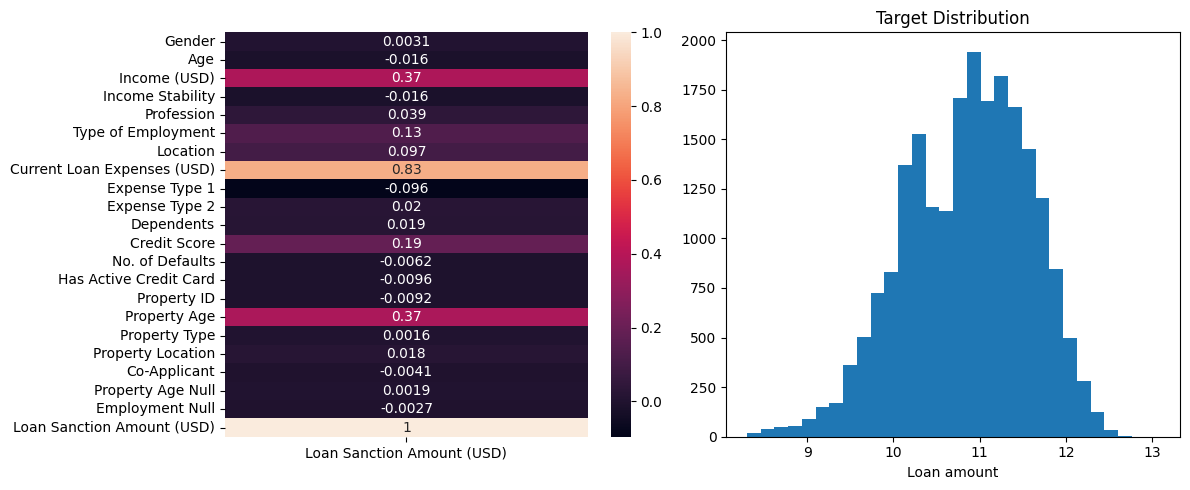

In [65]:


fig,axes = plt.subplots(nrows = 1, ncols=2, figsize=(12,5))


sns.heatmap(df.corr()[["Loan Sanction Amount (USD)"]],ax=axes[0],annot=True)

axes[1].hist(y["Loan Sanction Amount (USD)"], bins = 30)
axes[1].set_title("Target Distribution")
axes[1].set_xlabel("Loan amount")
plt.tight_layout()
plt.savefig(f"latex/images/target_analysis.pdf", bbox_inches='tight')
plt.show()

## Splitting Dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y["Loan Sanction Amount (USD)"], test_size=0.2, random_state=4)

print("Training size: ", len(X_train))
print("Test size: ", len(X_test))

Training size:  17165
Test size:  4292


## Logistic regression

In [66]:
def evaluate(model):
    start = time.time()
    model.fit(X_train, y_train)
    trained = time.time()

    fig,axes = plt.subplots(nrows=1, ncols=3, figsize = (12,4))

    print("Training time: ", trained-start)
    y_pred = model.predict(X_train)
    print("Training error: ")
    mse = mean_squared_error(y_train,y_pred)
    mae = mean_absolute_error(y_train,y_pred)
    print("MSE: ", mse)
    print("RMSE: ", mse**0.5)
    print("MAE: ", mae)
    r2 = r2_score(y_train,y_pred)

    print("R2 score: ", r2)

    n=len(X)
    p=len(X.columns)
    print("Adjusted R2 score: ", 1-(1-r2)*(n-1)/(n-p-1))

    axes[0].scatter(["MSE", "MAE", "1-R2"], [mse,mae,1-r2], c="#ff0000")
    axes[0].plot(["MSE", "MAE", "1-R2"], [mse,mae,1-r2], c="#ff0000", label = "Training error", linewidth = 0.5)

    y_pred = model.predict(X_test)
    print("Validation error: ")
    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    print("MSE: ", mse)
    print("RMSE: ", mse**0.5)
    print("MAE: ", mae)
    r2 = r2_score(y_test,y_pred)

    print("R2 score: ", r2)

    n=len(X)
    p=len(X.columns)
    print("Adjusted R2 score: ", 1-(1-r2)*(n-1)/(n-p-1))
    
    axes[0].scatter(["MSE", "MAE", "1-R2"], [mse,mae,1-r2], c="#0000ff")
    axes[0].plot(["MSE", "MAE", "1-R2"], [mse,mae,1-r2], c="#0000ff", label = "Validation error", linewidth=0.5)

    axes[0].legend()

    axes[1].scatter(y_test,y_pred)
    axes[1].set_title("Predicted vs Actual")
    axes[1].plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], c="#ff0000")
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')

    residuals = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=axes[2])
    axes[2].axhline(y=0, color='r', linestyle='--', lw=2) # Zero line
    axes[2].set_title('Residual Plot')
    axes[2].set_xlabel('Predicted Values')
    axes[2].set_ylabel('Residuals (Error)')

    try:
        weights = pd.DataFrame({
            'Feature': X_train.columns,
            'Weight': model.coef_
        })
    except AttributeError as e:
        weights = None

    plt.tight_layout()

    plt.savefig(f"latex/images/results_{model.__repr__()[:model.__repr__().index("(")]}.pdf", bbox_inches='tight') # Save as PDF

    plt.show()

    return weights





Training time:  0.015356779098510742
Training error: 
MSE:  0.15541053653663575
RMSE:  0.39422143084393035
MAE:  0.31319931518292354
R2 score:  0.7025644454056907
Adjusted R2 score:  0.7022730459820155
Validation error: 
MSE:  0.1570438492291261
RMSE:  0.3962875839956711
MAE:  0.31523089352043415
R2 score:  0.701200732988633
Adjusted R2 score:  0.7009079975276001


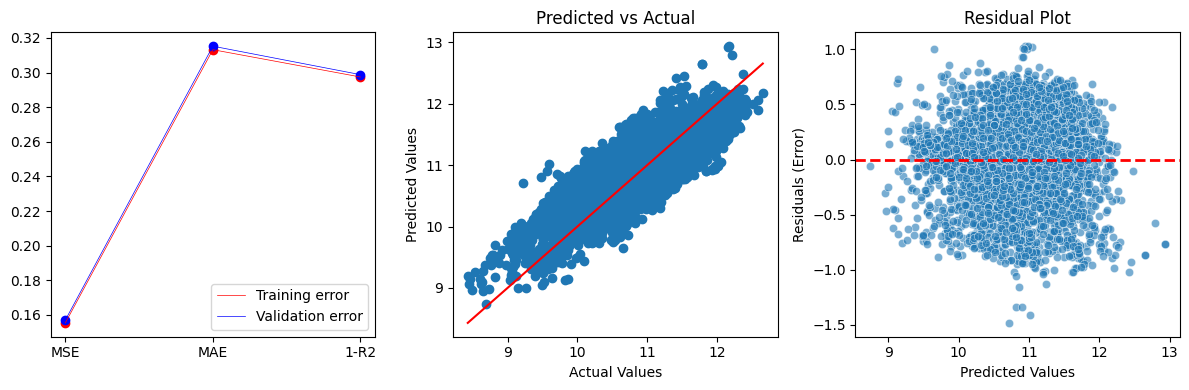

,Feature,Weight
0,Gender,-0.004086
1,Age,-0.001727
2,Income (USD),0.038214
3,Income Stability,0.007748
4,Profession,0.012884
5,Type of Employment,0.013163
6,Location,-0.015505
7,Current Loan Expenses (USD),0.585803
8,Expense Type 1,0.006983
9,Expense Type 2,0.041373


In [67]:
linear = LinearRegression()
evaluate(linear)


## Lasso Regression

[np.float64(0.05), np.float64(0.1), np.float64(0.15), np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.39999999999999997), np.float64(0.44999999999999996), np.float64(0.49999999999999994), np.float64(0.5499999999999999), np.float64(0.6), np.float64(0.65), np.float64(0.7), np.float64(0.75), np.float64(0.7999999999999999), np.float64(0.85), np.float64(0.9), np.float64(0.95), np.float64(1.0)]
[1e-05, 5e-06, 0.0001, 5e-05, 0.001, 0.0005, 0.01, 0.005, 0.1]


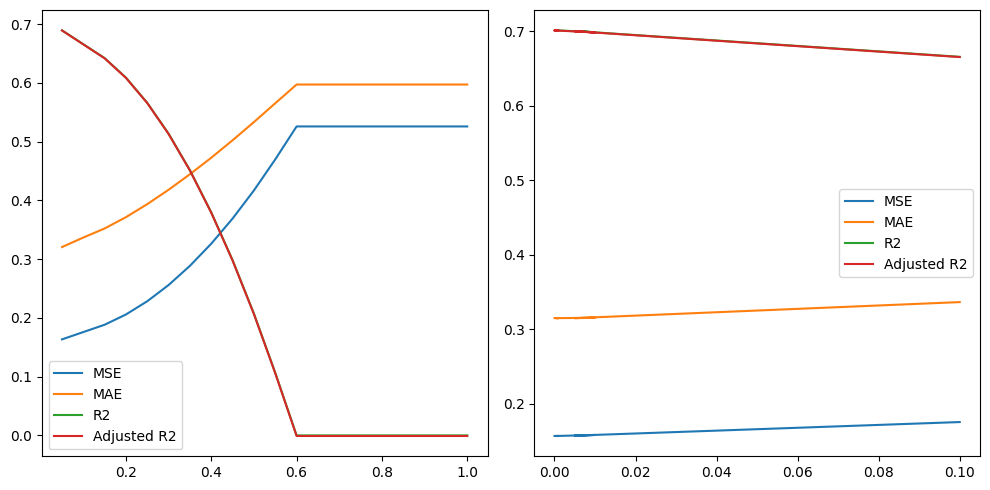

In [68]:
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

alpha_list = list(np.linspace(0.05,1,20))
print(alpha_list)
mse_list = []
mae_list = []
r2_list = []
ar2_list = []
for alpha in alpha_list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    y_pred = lasso.predict(X_test)
    mse_list.append(mean_squared_error(y_test,y_pred))
    mae_list.append(mean_absolute_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    r2_list.append(r2)

    n=len(X)
    p=len(X.columns)
    ar2_list.append(1-(1-r2)*(n-1)/(n-p-1))



axes[0].plot(alpha_list,mse_list, label = "MSE")
axes[0].plot(alpha_list,mae_list, label = "MAE")
axes[0].plot(alpha_list,r2_list, label = "R2")
axes[0].plot(alpha_list,ar2_list, label = "Adjusted R2")
axes[0].legend()


alpha_list = [10e-6, 5e-6, 10e-5, 5e-5, 10e-4, 5e-4, 10e-3, 5e-3, 10e-2]
print(alpha_list)
mse_list = []
mae_list = []
r2_list = []
ar2_list = []
for alpha in alpha_list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    y_pred = lasso.predict(X_test)
    mse_list.append(mean_squared_error(y_test,y_pred))
    mae_list.append(mean_absolute_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    r2_list.append(r2)

    n=len(X)
    p=len(X.columns)
    ar2_list.append(1-(1-r2)*(n-1)/(n-p-1))



axes[1].plot(alpha_list,mse_list, label = "MSE")
axes[1].plot(alpha_list,mae_list, label = "MAE")
axes[1].plot(alpha_list,r2_list, label = "R2")
axes[1].plot(alpha_list,ar2_list, label = "Adjusted R2")
axes[1].legend()
    
plt.tight_layout()
plt.savefig(f"latex/images/lasso_search.pdf", bbox_inches='tight')
plt.show()

Training time:  0.593740701675415
Training error: 
MSE:  0.1554567135066483
RMSE:  0.39427999379457274
MAE:  0.3131778544658181
R2 score:  0.7024760686907572
Adjusted R2 score:  0.7021845826838762
Validation error: 
MSE:  0.15704166088243826
RMSE:  0.39628482292719497
MAE:  0.31508540410313807
R2 score:  0.7012048966434943
Adjusted R2 score:  0.7009121652616195


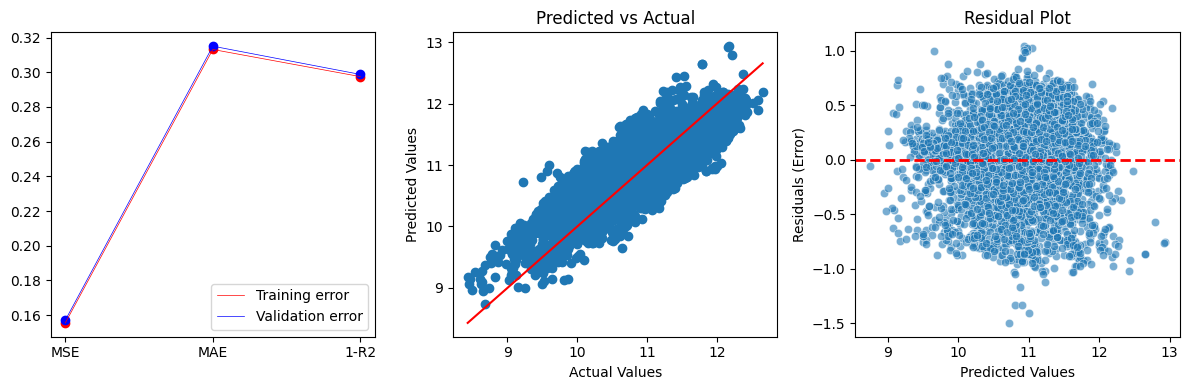

,Feature,Weight
0,Gender,-0.000228
1,Age,-0.000000
2,Income (USD),0.015573
3,Income Stability,0.000000
4,Profession,0.013131
5,Type of Employment,0.011657
6,Location,-0.014039
7,Current Loan Expenses (USD),0.585048
8,Expense Type 1,0.002176
9,Expense Type 2,0.036730


In [69]:

lasso = Lasso(alpha=0.001)
evaluate(lasso)

## Ridge Regression

[np.float64(0.0), np.float64(202.02020202020202), np.float64(404.04040404040404), np.float64(606.060606060606), np.float64(808.0808080808081), np.float64(1010.1010101010102), np.float64(1212.121212121212), np.float64(1414.141414141414), np.float64(1616.1616161616162), np.float64(1818.1818181818182), np.float64(2020.2020202020203), np.float64(2222.222222222222), np.float64(2424.242424242424), np.float64(2626.2626262626263), np.float64(2828.282828282828), np.float64(3030.3030303030305), np.float64(3232.3232323232323), np.float64(3434.343434343434), np.float64(3636.3636363636365), np.float64(3838.3838383838383), np.float64(4040.4040404040406), np.float64(4242.424242424242), np.float64(4444.444444444444), np.float64(4646.464646464647), np.float64(4848.484848484848), np.float64(5050.50505050505), np.float64(5252.525252525253), np.float64(5454.545454545455), np.float64(5656.565656565656), np.float64(5858.585858585859), np.float64(6060.606060606061), np.float64(6262.626262626262), np.float64(

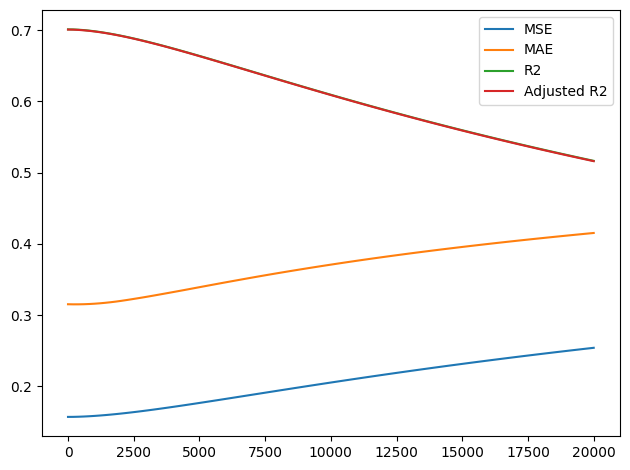

In [70]:

alpha_list = list(np.linspace(0,20000,100))
print(alpha_list)
mse_list = []
mae_list = []
r2_list = []
ar2_list = []
for alpha in alpha_list:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    y_pred = ridge.predict(X_test)
    mse_list.append(mean_squared_error(y_test,y_pred))
    mae_list.append(mean_absolute_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    r2_list.append(r2)

    n=len(X)
    p=len(X.columns)
    ar2_list.append(1-(1-r2)*(n-1)/(n-p-1))



plt.plot(alpha_list,mse_list, label = "MSE")
plt.plot(alpha_list,mae_list, label = "MAE")
plt.plot(alpha_list,r2_list, label = "R2")
plt.plot(alpha_list,ar2_list, label = "Adjusted R2")
plt.legend()

plt.tight_layout()
plt.savefig(f"latex/images/ridge_search.pdf", bbox_inches='tight')
plt.show()
    

Training time:  0.009601831436157227
Training error: 
MSE:  0.15541053874810049
RMSE:  0.3942214336487813
MAE:  0.3131983715402833
R2 score:  0.7025644411732348
Adjusted R2 score:  0.7022730417454128
Validation error: 
MSE:  0.15704359987614774
RMSE:  0.39628726938440473
MAE:  0.3152298334797554
R2 score:  0.7012012074197393
Adjusted R2 score:  0.7009084724235095


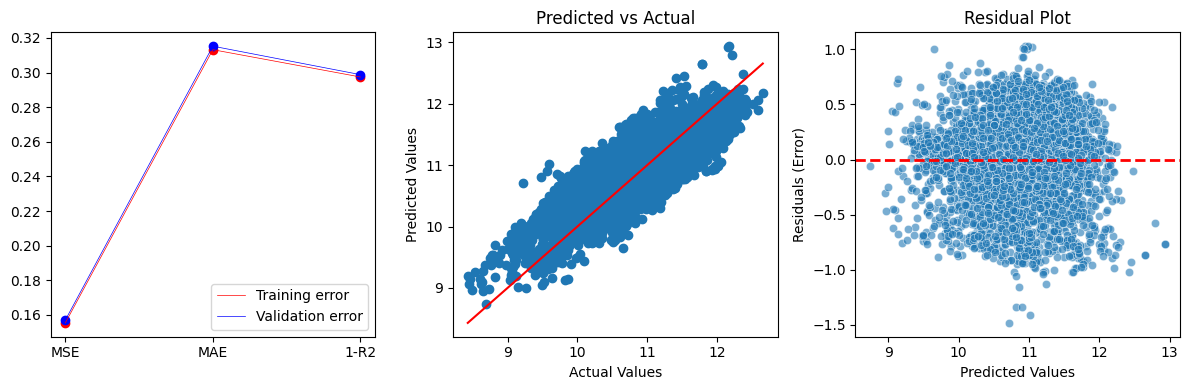

,Feature,Weight
0,Gender,-0.004085
1,Age,-0.001726
2,Income (USD),0.038006
3,Income Stability,0.007729
4,Profession,0.012885
5,Type of Employment,0.013164
6,Location,-0.015501
7,Current Loan Expenses (USD),0.585762
8,Expense Type 1,0.006977
9,Expense Type 2,0.041362


In [71]:
ridge = Ridge(alpha = 1)
evaluate(ridge)

## Elastic Net Regression

[np.float64(0.1), np.float64(0.2), np.float64(0.30000000000000004), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7000000000000001), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(1.1), np.float64(1.2000000000000002), np.float64(1.3000000000000003), np.float64(1.4000000000000001), np.float64(1.5000000000000002), np.float64(1.6), np.float64(1.7000000000000002), np.float64(1.8000000000000003), np.float64(1.9000000000000001), np.float64(2.0), np.float64(2.1), np.float64(2.2), np.float64(2.3000000000000003), np.float64(2.4000000000000004), np.float64(2.5000000000000004), np.float64(2.6), np.float64(2.7), np.float64(2.8000000000000003), np.float64(2.9000000000000004), np.float64(3.0000000000000004), np.float64(3.1), np.float64(3.2), np.float64(3.3000000000000003), np.float64(3.4000000000000004), np.float64(3.5000000000000004), np.float64(3.6), np.float64(3.7), np.float64(3.8000000000000003), np.float64(3.9000000000000004), np.float64(4.0), np.float64(4.1), n

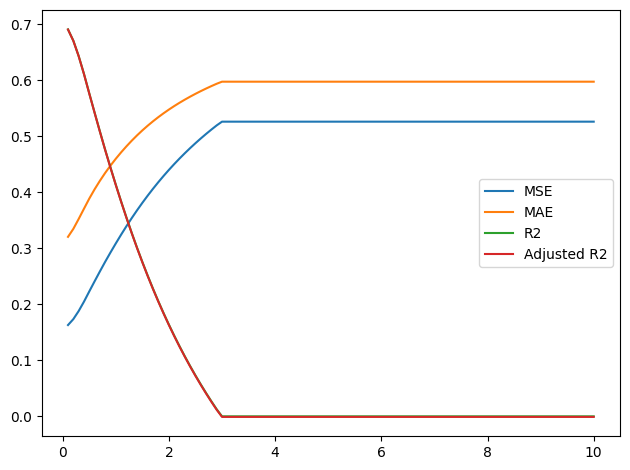

In [72]:
alpha_list = list(np.linspace(0.1, 10,100))
print(alpha_list)
mse_list = []
mae_list = []
r2_list = []
ar2_list = []
for alpha in alpha_list:
    elastic = ElasticNet(alpha=alpha, l1_ratio=0.2)
    elastic.fit(X_train,y_train)
    y_pred = elastic.predict(X_test)
    mse_list.append(mean_squared_error(y_test,y_pred))
    mae_list.append(mean_absolute_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    r2_list.append(r2)

    n=len(X)
    p=len(X.columns)
    ar2_list.append(1-(1-r2)*(n-1)/(n-p-1))



plt.plot(alpha_list,mse_list, label = "MSE")
plt.plot(alpha_list,mae_list, label = "MAE")
plt.plot(alpha_list,r2_list, label = "R2")
plt.plot(alpha_list,ar2_list, label = "Adjusted R2")
plt.legend()

plt.tight_layout()
plt.savefig(f"latex/images/elastic_search.pdf", bbox_inches='tight')
plt.show()

Training time:  0.11597895622253418
Training error: 
MSE:  0.16071822617056591
RMSE:  0.4008967774509617
MAE:  0.31813385706116093
R2 score:  0.6924062177522503
Adjusted R2 score:  0.6921048662510978
Validation error: 
MSE:  0.1627032097151063
RMSE:  0.4033648592962782
MAE:  0.32014839188713734
R2 score:  0.6904329584258941
Adjusted R2 score:  0.6901296737105661


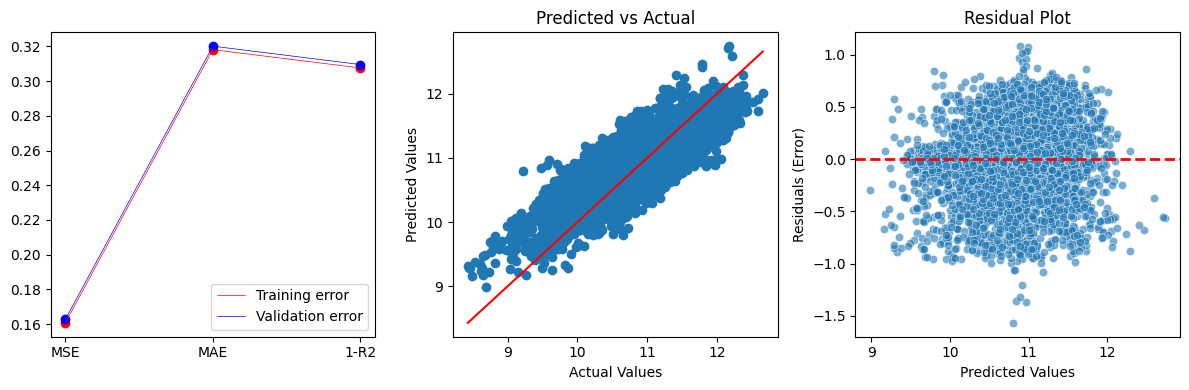

,Feature,Weight
0,Gender,-0.000000
1,Age,0.000000
2,Income (USD),0.014405
3,Income Stability,0.000000
4,Profession,0.000000
5,Type of Employment,0.000832
6,Location,-0.000000
7,Current Loan Expenses (USD),0.522390
8,Expense Type 1,-0.000000
9,Expense Type 2,0.000000


In [73]:
elasticnet = ElasticNet(alpha=0.1,l1_ratio=0.2)
evaluate(elasticnet)

## Simple Vector Regressor

Training time:  21.574070692062378
Training error: 
MSE:  0.12307650471357945
RMSE:  0.350822611462801
MAE:  0.2674079208723446
R2 score:  0.7644475770252361
Adjusted R2 score:  0.7642168048823638
Validation error: 
MSE:  0.1647739594131462
RMSE:  0.4059235881457817
MAE:  0.32302659085615476
R2 score:  0.6864930493178615
Adjusted R2 score:  0.6861859046495935


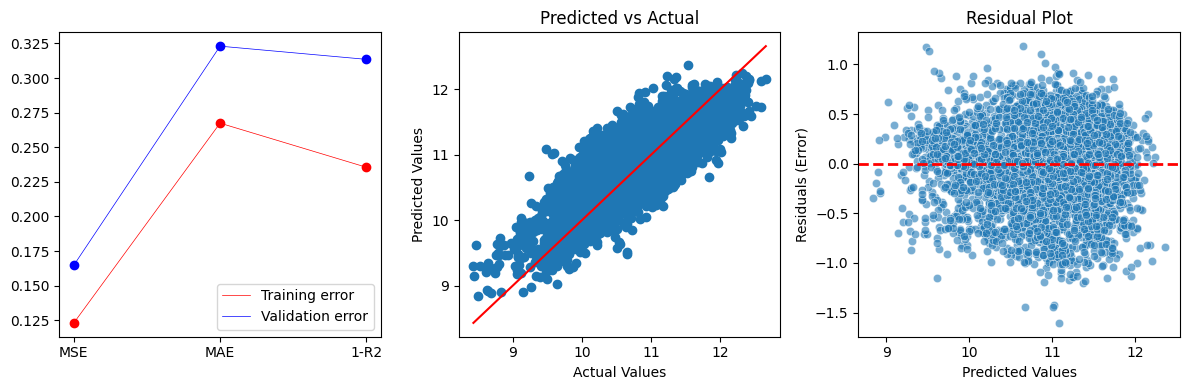

In [74]:
svr = SVR()
evaluate(svr)

## hyper parameter tuning

In [24]:
cv_5_fold = KFold(n_splits=5, shuffle=True, random_state=2)

lasso = Lasso()

params = {
    "alpha": np.logspace(-5,-2,20,base=10)
}

grid_search = GridSearchCV(
    lasso,
    param_grid=params,
    cv=cv_5_fold,
    n_jobs=-1
)

grid_search.fit(X_train,y_train)

lasso_best_alpha = grid_search.best_params_["alpha"]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Val Score: {grid_search.best_score_:.4f}")

Best Parameters: {'alpha': np.float64(0.001623776739188721)}
Best Cross-Val Score: 0.7016


In [25]:
cv_5_fold = KFold(n_splits=5, shuffle=True, random_state=2)

ridge = Ridge()

params = {
    "alpha": np.linspace(1,1000,20)
}

grid_search = GridSearchCV(
    ridge,
    param_grid=params,
    cv=cv_5_fold,
    n_jobs=-1
)

grid_search.fit(X_train,y_train)

ridge_best_alpha = grid_search.best_params_["alpha"]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Val Score: {grid_search.best_score_:.4f}")

Best Parameters: {'alpha': np.float64(53.578947368421055)}
Best Cross-Val Score: 0.7015


In [26]:
cv_5_fold = KFold(n_splits=5, shuffle=True, random_state=2)

elasticnet = ElasticNet()

params = {
    "alpha": np.logspace(-5,1,50,base=10),
    "l1_ratio": np.linspace(0,1,10)
}

grid_search = GridSearchCV(
    elasticnet,
    param_grid=params,
    cv=cv_5_fold,
    n_jobs=-1
)

grid_search.fit(X_train,y_train)

elastic_best_alpha = grid_search.best_params_["alpha"]
elastic_best_l1_ratio = grid_search.best_params_["l1_ratio"]

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Val Score: {grid_search.best_score_:.4f}")

Best Parameters: {'alpha': np.float64(0.0015998587196060573), 'l1_ratio': np.float64(1.0)}
Best Cross-Val Score: 0.7016


In [28]:
cv_5_fold = KFold(n_splits=5, shuffle=True, random_state=2)

svr = SVR()

params = [
    {
        "kernel": ["linear"],
        "C": [0.1,1,10,100],
    },
    {
        "kernel": ["poly"],
        "C": [0.1,1,10],
        "degree": [2,3,4]
    },
    {
        "kernel": ["rbf", "sigmoid"],
        "C": [0.1,1,10],
        "gamma": ["scale", "auto"],
    }
]

grid_search = GridSearchCV(
    svr,
    param_grid=params,
    cv=cv_5_fold,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train,y_train)

svr_best = grid_search.best_params_


# got -
# Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
# Best Cross-Val Score: 0.7642

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Val Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: 

In [29]:
svr_best = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

In [30]:
# preprocessing test data

X_testset = test_df.copy()
X_testset.drop(["Customer ID", "Name","Loan Amount Request (USD)", "Property Price"],axis = 1, inplace=True)
X_testset["Property Age Null"] = X_testset["Property Age"].isna().astype(int)
X_testset["Employment Null"] = X_testset["Type of Employment"].isna().astype(int)
X_testset["Co-Applicant"] = X_testset["Co-Applicant"].replace("?", np.nan).astype(float)



for column in ordinal_encodings:
    encoder = OrdinalEncoder(
        categories=[ordinal_encodings[column]],
        handle_unknown="use_encoded_value",
        unknown_value=np.nan
    )
    encoder.set_output(transform="pandas")
    X_testset[column] = encoder.fit_transform(X_testset[[column]])

X_testset.fillna(X_testset.mean(),inplace=True)


In [33]:
## final models: 

linear = LinearRegression()
lasso = Lasso(alpha=lasso_best_alpha)
ridge = Ridge(alpha = ridge_best_alpha)
elastic = ElasticNet(alpha = elastic_best_alpha, l1_ratio=elastic_best_l1_ratio)
svr = SVR(**svr_best)

p=len(X.columns)

modelnames = ["linear","lasso", "ridge","elasticnet", "svr"]
i=0

for model in [linear,lasso,ridge,elastic,svr]:
    model.fit(X_train, y_train, )
    print("\nModel: ", modelnames[i])
    y_pred = model.predict(X_train)

    print("Training Metrics: ")
    print("\tMSE: ", mean_squared_error(y_train,y_pred))
    print("\tRMSE: ", mean_squared_error(y_train,y_pred)**0.5)
    print("\tMAE: ", mean_absolute_error(y_train,y_pred))
    r2 = r2_score(y_train,y_pred)
    print("\tR2 score: ", r2)
    n=len(X_train)
    print("\tAdjusted R2 score: ", 1-(1-r2)*(n-1)/(n-p-1))

    y_pred = model.predict(X_test)

    print("Validation Metrics: ")
    print("\tMSE: ", mean_squared_error(y_test,y_pred))
    print("\tRMSE: ", mean_squared_error(y_test,y_pred)**0.5)
    print("\tMAE: ", mean_absolute_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    print("\tR2 score: ", r2)
    n=len(X_test)
    print("\tAdjusted R2 score: ", 1-(1-r2)*(n-1)/(n-p-1))

    y_pred = model.predict(X_testset)
    pd.DataFrame({
        "Prediction": y_pred
    }).to_csv(f"prediciton_{modelnames[i]}.csv",index=False)
    i+=1





Model:  linear
Training Metrics: 
	MSE:  0.15541053653663575
	RMSE:  0.39422143084393035
	MAE:  0.31319931518292354
	R2 score:  0.7025644454056907
	Adjusted R2 score:  0.7022000898876086
Validation Metrics: 
	MSE:  0.1570438492291261
	RMSE:  0.3962875839956711
	MAE:  0.31523089352043415
	R2 score:  0.701200732988633
	Adjusted R2 score:  0.6997312283967738

Model:  lasso
Training Metrics: 
	MSE:  0.1554864226638807
	RMSE:  0.39431766719724937
	MAE:  0.31315767487894197
	R2 score:  0.702419209227719
	Adjusted R2 score:  0.7020546757968016
Validation Metrics: 
	MSE:  0.15708175562238644
	RMSE:  0.39633540798468464
	MAE:  0.31505453391664046
	R2 score:  0.7011286104408425
	Adjusted R2 score:  0.6996587511479286

Model:  ridge
Training Metrics: 
	MSE:  0.1554158256811755
	RMSE:  0.3942281391290778
	MAE:  0.313153859916946
	R2 score:  0.7025543226709356
	Adjusted R2 score:  0.7021899547526069
Validation Metrics: 
	MSE:  0.15704108233651398
	RMSE:  0.39628409296426975
	MAE:  0.31517992089061